# Set-up

In [54]:
# --- Standard library ---
import sys
import os

# --- Scientific computing ---
import numpy as np
import scipy.stats as stats

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# --- Network science ---
import networkx as nx

# --- Data handling and visualization ---
import pandas as pd

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# --- Project source code ---
sys.path.append("../../src/")

from classifiers.features import get_degrees, get_configuration_probabilities_feature
from classifiers.features import get_distances, get_configuration_distances_feature, get_distance_ratios_feature
# from classifiers.features import get_labels, format_feature_matrix
from classifiers.logreg import *
from data.observations import get_preprocessed_data

In [55]:
SYSTEM = "drosophila"
LAYERS = [1, 2]
REP = 1

THETAS = [0.05,0.07,0.10,0.12,0.15,0.17,0.20,0.22,0.25,0.27,0.30,0.32,0.35,0.37,0.40,0.42,0.45,0.47,0.50,0.53,0.55,0.57,0.60,0.62,0.65,0.68,0.70,0.72,0.75,0.78,0.80,0.82,0.85,0.88,0.90,0.92,0.95]
# THETA = 0.50  # before threshold
# THETA = 0.65  # approaching threshold from the left
THETA = 0.68  # approaching threshold from the right
# THETA = 0.85  # after threshold

MIN = 0
INF = 0.5
SUP = 0.7

In [56]:
def preprocess_dataframe(SYSTEM, LAYERS, THETA, REP):
    cache = get_preprocessed_data(SYSTEM, LAYERS, THETA, REP)
    cache.embeddings = cache.renormalize()
    cache.embeddings = cache.align_centers()

    edges = cache.observed_edges.copy()
    edges.update(cache.unobserved_edges)

    distances_G, distances_H = get_distances(cache.embeddings, edges.keys())
    feature_c = get_configuration_distances_feature(distances_G, distances_H, zde_penalty=0.1)
    feature_r = get_distance_ratios_feature(distances_G, distances_H, zde_penalty=0.1)

    degrees_G, degrees_H = get_degrees(cache.remnants, edges.keys())
    feature_d = get_configuration_probabilities_feature(degrees_G, degrees_H)

    df = pd.DataFrame({
        "theta": [THETA]*len(edges),
        "edge": edges.keys(),
        "layer_actual": edges.values(),
        "distance_G": distances_G,
        "distance_H": distances_H,
        "feature_c": feature_c,
        "feature_r": feature_r,
        "feature_d": feature_d
    })

    # Adding useful transformation for unbounded feature
    df["log_ratio"] = df["feature_r"].transform(np.log10)

    # Notating TTS
    df["tts"] = [
        "Train" if row[1]["edge"] in cache.observed_edges else "Test"
        for row in df.iterrows()
    ]

    return df

def melt_dataframe(df):
    # Melting main quantitative variables
    df_melted = df.melt(
        id_vars=["theta", "edge", "layer_actual", "distance_G", "distance_H"],
        value_vars=["feature_d", "feature_c", "feature_r", "log_ratio"],
        var_name="feature_type", value_name="feature_value"
    )
    df_melted = df_melted.melt(
        id_vars=["theta", "edge", "layer_actual", "feature_type", "feature_value"],
        value_vars=["distance_G", "distance_H"],
        var_name="distance_layer", value_name="distance"
    )
    df_melted = df_melted.replace({
        "distance_G": "G",
        "distance_H": "H",
        "feature_d": "Degree",
        "feature_c": "Configuration",
        "feature_r": "Ratio",
        "log_ratio": "LogRatio"
    })

    return df_melted

## Scripting IRLS

In [57]:
def get_mu(betas, x):
    linear_response = np.dot(betas, x)
    logit_response = 1 / (1 + np.exp(-linear_response))

    return logit_response

def get_expected_values(betas, X):
    return np.array([get_mu(betas, x) for x in X])

In [58]:
def get_reweight(expected_values):
    return expected_values * (1 - expected_values)

In [59]:
def update_betas(X, Y, betas, mu, S):
    Xt = np.transpose(X)

    A = np.ones_like(Xt)
    A[0, :] = S
    for i in range(len(Y)):
        A[1, i] = S[i]*Xt[1, i]

    A = np.matmul(A, X)
    A = np.linalg.inv(A)

    B = np.matmul(A, Xt)

    C = np.zeros_like(X)
    for i in range(len(Y)):
        C[i, :] = S[i] * X[i, :]

    C = np.dot(C, betas) + Y - mu

    betas = np.dot(B, C)

    return betas

In [69]:
def irls_sweep(df):
    _df = df.query("distance_G > @MIN and distance_H > @MIN")
    converged_betas = []
    rocs = []
    prs = []
    aurocs = []
    auprs = []
    accuracies = []
    precisions = []
    recalls = []

    for THETA in THETAS:
        df_ = melt_dataframe(_df.query("theta == @THETA")).query("feature_type == 'Configuration'")

        X = np.ones((len(df_), 2))
        X[:, 1] = df_["feature_value"]

        Y = np.array(df_["layer_actual"])

        betas_ = [1, 1]
        mu_ = get_expected_values(betas_, X)
        S_ = get_reweight(mu_)

        # ------------------------------
        K = 10
        betas = np.zeros((K+1, 2))
        betas[0,:] = betas_

        for i in range(K):
            try:
                betas_ = update_betas(X, Y, betas_, mu_, S_)
                mu_ = get_expected_values(betas_, X)
                S_ = get_reweight(mu_)
            except np.linalg.LinAlgError:
                continue

            betas[i+1, :] = betas_

        mu_binary = [1 if y >= 0.5 else 0 for y in mu_]

        rocs.append(roc_curve(Y, mu_))
        pr = precision_recall_curve(Y, mu_)
        prs.append(pr)

        aurocs.append(roc_auc_score(Y, mu_))
        auprs.append(auc(pr[1], pr[0]))
        accuracies.append(accuracy_score(Y, mu_binary))
        precisions.append(precision_score(Y, mu_binary))
        recalls.append(recall_score(Y, mu_binary))

        converged_betas.append(betas[-1, :])

    return rocs, prs, aurocs, auprs, accuracies, precisions, recalls, converged_betas

# IRLS θ-Sweep

## arXiv

In [70]:
SYSTEM = "arxiv"
if not os.path.isfile(f"{SYSTEM}.csv"):
    df = preprocess_dataframe(SYSTEM, [2,6], 0.05, REP)
    for THETA in THETAS[1:]:
        df = pd.concat([df, preprocess_dataframe(SYSTEM, [2,6], THETA, REP)])

    df.index = range(len((df)))
    df.to_csv(f"{SYSTEM}.csv")
else:
    df = pd.read_csv(f"{SYSTEM}.csv")

rocs, prs, aurocs, auprs, accuracies, precisions, recalls, converged_betas = irls_sweep(df)
converged_betas = np.array(converged_betas)

Text(0.5, 1.0, 'IRLS-based Precision-Recall curves')

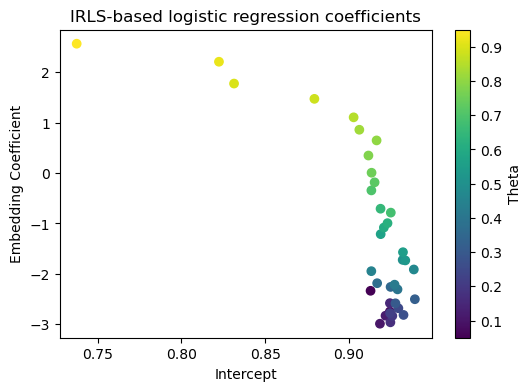

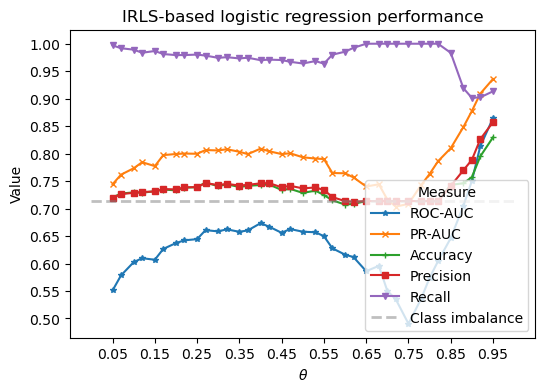

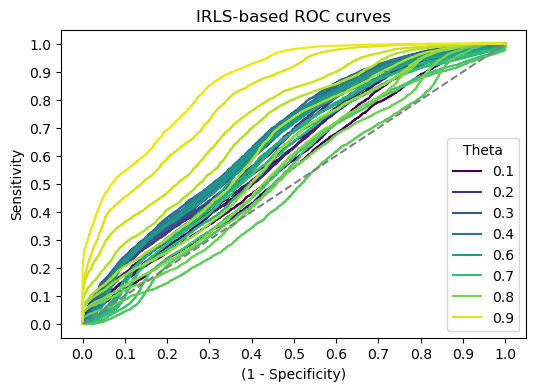

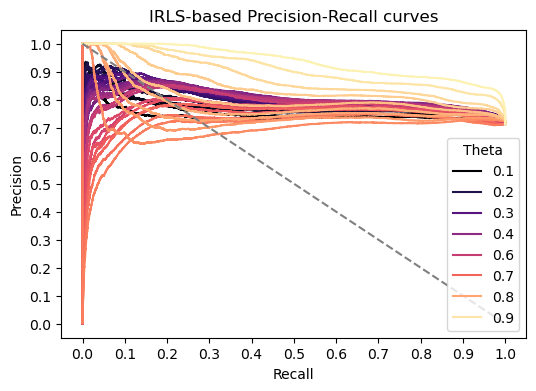

In [71]:
plt.figure(figsize=(6,4))

plt.scatter(converged_betas[:, 0], converged_betas[:, 1], c=THETAS)

plt.colorbar(label="Theta")
plt.xlabel("Intercept")
plt.ylabel("Embedding Coefficient")

plt.title("IRLS-based logistic regression coefficients")

plt.figure(figsize=(6,4))

plt.plot(THETAS, aurocs, marker="*", markersize=4, label="ROC-AUC")
plt.plot(THETAS, auprs, marker="x", markersize=4, label="PR-AUC")
plt.plot(THETAS, accuracies, marker="+", markersize=4, label="Accuracy")
plt.plot(THETAS, precisions, marker="s", markersize=4, label="Precision")
plt.plot(THETAS, recalls, marker="v", markersize=4, label="Recall")
plt.hlines(df["layer_actual"].value_counts()[1] / df["layer_actual"].value_counts().sum(), 0, 1, linestyle="--", linewidth=2, color="gray", alpha=0.5, label="Class imbalance")

plt.legend(title="Measure")
plt.xticks(THETAS[::4])
plt.yticks(np.linspace(0.5,1,11))
plt.xlabel("$\\theta$")
plt.ylabel("Value")

plt.title("IRLS-based logistic regression performance")


viridis = mpl.colormaps["viridis"]

plt.figure(figsize=(6,4))

for idx, theta in enumerate(THETAS):
    curve = rocs[idx]
    if idx % 5 == 0:
        plt.plot(curve[0], curve[1], color=viridis(idx/len(THETAS)), label=f"{theta:.1f}")
    else:
        plt.plot(curve[0], curve[1], color=viridis(idx/len(THETAS)))

plt.plot(np.linspace(0,1), np.linspace(0,1), linestyle="--", color="gray")

plt.legend(title="Theta")
plt.xticks(np.linspace(0,1,11))
plt.yticks(np.linspace(0,1,11))
plt.xlabel("(1 - Specificity)")
plt.ylabel("Sensitivity")

plt.title("IRLS-based ROC curves")

viridis = mpl.colormaps["magma"]

plt.figure(figsize=(6,4))

for idx, theta in enumerate(THETAS):
    curve = prs[idx]
    if idx % 5 == 0:
        plt.plot(curve[1], curve[0], color=viridis(idx/len(THETAS)), label=f"{theta:.1f}")
    else:
        plt.plot(curve[1], curve[0], color=viridis(idx/len(THETAS)))

plt.plot(np.linspace(0,1), 1-np.linspace(0,1), linestyle="--", color="gray")

plt.legend(title="Theta")
plt.xticks(np.linspace(0,1,11))
plt.yticks(np.linspace(0,1,11))
plt.xlabel("Recall")
plt.ylabel("Precision")

plt.title("IRLS-based Precision-Recall curves")

## _C. Elegans_

In [63]:
SYSTEM = "celegans"
if not os.path.isfile(f"{SYSTEM}.csv"):
    df = preprocess_dataframe(SYSTEM, LAYERS, 0.05, REP)
    for THETA in THETAS[1:]:
        df = pd.concat([df, preprocess_dataframe(SYSTEM, LAYERS, THETA, REP)])

    df.index = range(len((df)))
    df.to_csv(f"{SYSTEM}.csv")
else:
    df = pd.read_csv(f"{SYSTEM}.csv")

rocs, prs, aurocs, auprs, accuracies, precisions, recalls, converged_betas = irls_sweep(df)
converged_betas = np.array(converged_betas)

Text(0.5, 1.0, 'IRLS-based Precision-Recall curves')

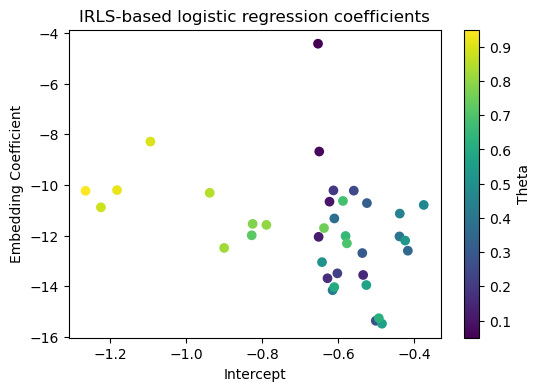

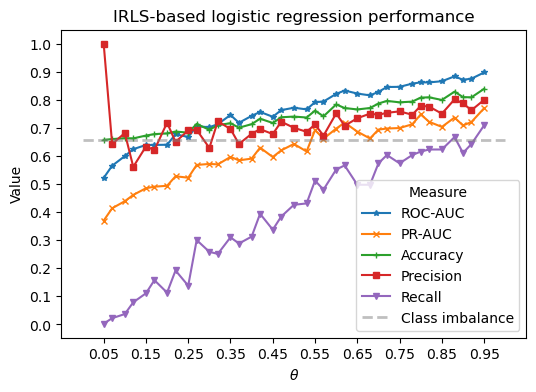

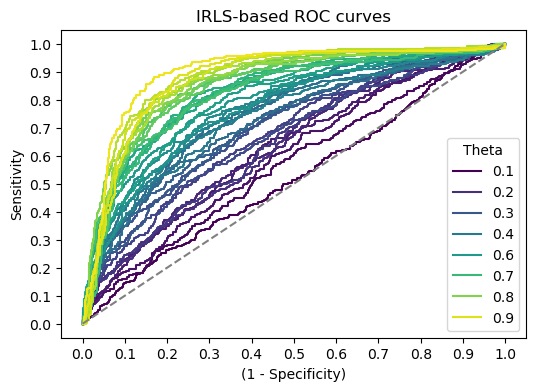

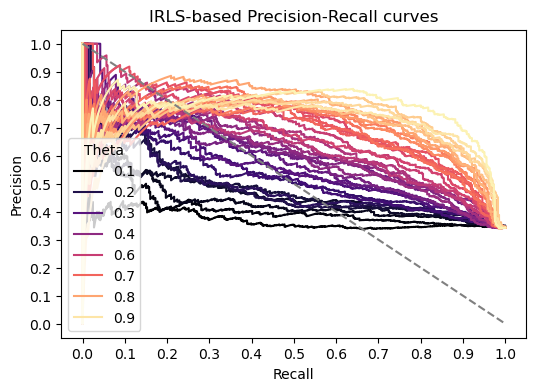

In [64]:
plt.figure(figsize=(6,4))

plt.scatter(converged_betas[:, 0], converged_betas[:, 1], c=THETAS)

plt.colorbar(label="Theta")
plt.xlabel("Intercept")
plt.ylabel("Embedding Coefficient")

plt.title("IRLS-based logistic regression coefficients")

plt.figure(figsize=(6,4))

plt.plot(THETAS, aurocs, marker="*", markersize=4, label="ROC-AUC")
plt.plot(THETAS, auprs, marker="x", markersize=4, label="PR-AUC")
plt.plot(THETAS, accuracies, marker="+", markersize=4, label="Accuracy")
plt.plot(THETAS, precisions, marker="s", markersize=4, label="Precision")
plt.plot(THETAS, recalls, marker="v", markersize=4, label="Recall")
plt.hlines(df["layer_actual"].value_counts()[0] / df["layer_actual"].value_counts().sum(), 0, 1, linestyle="--", linewidth=2, color="gray", alpha=0.5, label="Class imbalance")

plt.legend(title="Measure")
plt.xticks(THETAS[::4])
plt.yticks(np.linspace(0.0,1,11))
plt.xlabel("$\\theta$")
plt.ylabel("Value")

plt.title("IRLS-based logistic regression performance")

viridis = mpl.colormaps["viridis"]

plt.figure(figsize=(6,4))

for idx, theta in enumerate(THETAS):
    curve = rocs[idx]
    if idx % 5 == 0:
        plt.plot(curve[0], curve[1], color=viridis(idx/len(THETAS)), label=f"{theta:.1f}")
    else:
        plt.plot(curve[0], curve[1], color=viridis(idx/len(THETAS)))

plt.plot(np.linspace(0,1), np.linspace(0,1), linestyle="--", color="gray")

plt.legend(title="Theta")
plt.xticks(np.linspace(0,1,11))
plt.yticks(np.linspace(0,1,11))
plt.xlabel("(1 - Specificity)")
plt.ylabel("Sensitivity")

plt.title("IRLS-based ROC curves")

viridis = mpl.colormaps["magma"]

plt.figure(figsize=(6,4))

for idx, theta in enumerate(THETAS):
    curve = prs[idx]
    if idx % 5 == 0:
        plt.plot(curve[1], curve[0], color=viridis(idx/len(THETAS)), label=f"{theta:.1f}")
    else:
        plt.plot(curve[1], curve[0], color=viridis(idx/len(THETAS)))

plt.plot(np.linspace(0,1), 1-np.linspace(0,1), linestyle="--", color="gray")

plt.legend(title="Theta")
plt.xticks(np.linspace(0,1,11))
plt.yticks(np.linspace(0,1,11))
plt.xlabel("Recall")
plt.ylabel("Precision")

plt.title("IRLS-based Precision-Recall curves")

## _Drosophila_

In [65]:
SYSTEM = "drosophila"
if not os.path.isfile(f"{SYSTEM}.csv"):
    df = preprocess_dataframe(SYSTEM, LAYERS, 0.05, REP)
    for THETA in THETAS[1:]:
        df = pd.concat([df, preprocess_dataframe(SYSTEM, LAYERS, THETA, REP)])

    df.index = range(len((df)))
    df.to_csv(f"{SYSTEM}.csv")
else:
    df = pd.read_csv(f"{SYSTEM}.csv")

rocs, prs, aurocs, auprs, accuracies, precisions, recalls, converged_betas = irls_sweep(df)
converged_betas = np.array(converged_betas)

Text(0.5, 1.0, 'IRLS-based Precision-Recall curves')

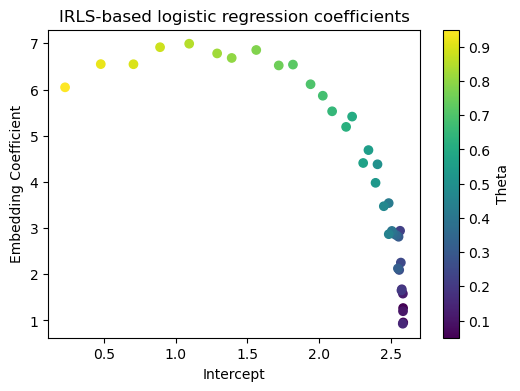

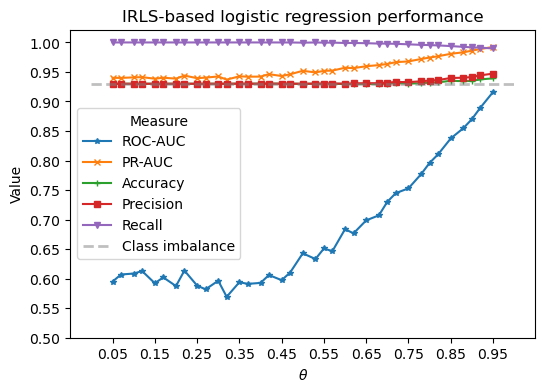

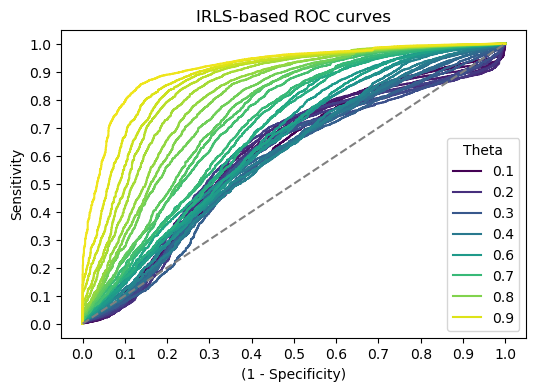

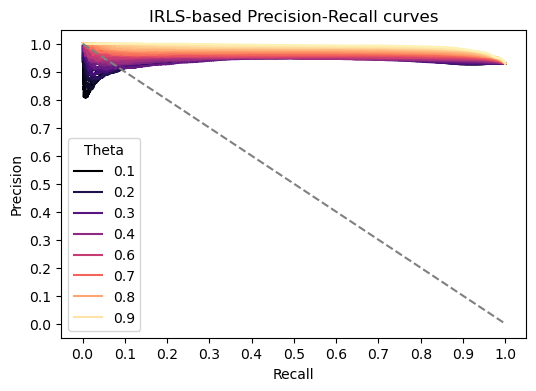

In [66]:
plt.figure(figsize=(6,4))

plt.scatter(converged_betas[:, 0], converged_betas[:, 1], c=THETAS)

plt.colorbar(label="Theta")
plt.xlabel("Intercept")
plt.ylabel("Embedding Coefficient")

plt.title("IRLS-based logistic regression coefficients")

plt.figure(figsize=(6,4))

plt.plot(THETAS, aurocs, marker="*", markersize=4, label="ROC-AUC")
plt.plot(THETAS, auprs, marker="x", markersize=4, label="PR-AUC")
plt.plot(THETAS, accuracies, marker="+", markersize=4, label="Accuracy")
plt.plot(THETAS, precisions, marker="s", markersize=4, label="Precision")
plt.plot(THETAS, recalls, marker="v", markersize=4, label="Recall")
plt.hlines(df["layer_actual"].value_counts()[1] / df["layer_actual"].value_counts().sum(), 0, 1, linestyle="--", linewidth=2, color="gray", alpha=0.5, label="Class imbalance")

plt.legend(title="Measure")
plt.xticks(THETAS[::4])
plt.yticks(np.linspace(0.5,1,11))
plt.xlabel("$\\theta$")
plt.ylabel("Value")

plt.title("IRLS-based logistic regression performance")


viridis = mpl.colormaps["viridis"]

plt.figure(figsize=(6,4))

for idx, theta in enumerate(THETAS):
    curve = rocs[idx]
    if idx % 5 == 0:
        plt.plot(curve[0], curve[1], color=viridis(idx/len(THETAS)), label=f"{theta:.1f}")
    else:
        plt.plot(curve[0], curve[1], color=viridis(idx/len(THETAS)))

plt.plot(np.linspace(0,1), np.linspace(0,1), linestyle="--", color="gray")

plt.legend(title="Theta")
plt.xticks(np.linspace(0,1,11))
plt.yticks(np.linspace(0,1,11))
plt.xlabel("(1 - Specificity)")
plt.ylabel("Sensitivity")

plt.title("IRLS-based ROC curves")

viridis = mpl.colormaps["magma"]

plt.figure(figsize=(6,4))

for idx, theta in enumerate(THETAS):
    curve = prs[idx]
    if idx % 5 == 0:
        plt.plot(curve[1], curve[0], color=viridis(idx/len(THETAS)), label=f"{theta:.1f}")
    else:
        plt.plot(curve[1], curve[0], color=viridis(idx/len(THETAS)))

plt.plot(np.linspace(0,1), 1-np.linspace(0,1), linestyle="--", color="gray")

plt.legend(title="Theta")
plt.xticks(np.linspace(0,1,11))
plt.yticks(np.linspace(0,1,11))
plt.xlabel("Recall")
plt.ylabel("Precision")

plt.title("IRLS-based Precision-Recall curves")

## London

In [67]:
SYSTEM = "london"
if not os.path.isfile(f"{SYSTEM}.csv"):
    df = preprocess_dataframe(SYSTEM, LAYERS, 0.05, REP)
    for THETA in THETAS[1:]:
        df = pd.concat([df, preprocess_dataframe(SYSTEM, LAYERS, THETA, REP)])

    df.index = range(len((df)))
    df.to_csv(f"{SYSTEM}.csv")
else:
    df = pd.read_csv(f"{SYSTEM}.csv")

rocs, prs, aurocs, auprs, accuracies, precisions, recalls, converged_betas = irls_sweep(df)
converged_betas = np.array(converged_betas)

Text(0.5, 1.0, 'IRLS-based Precision-Recall curves')

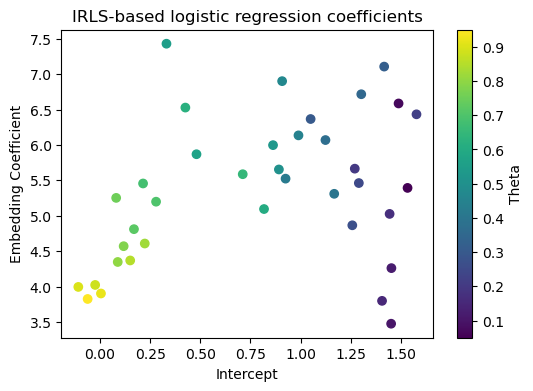

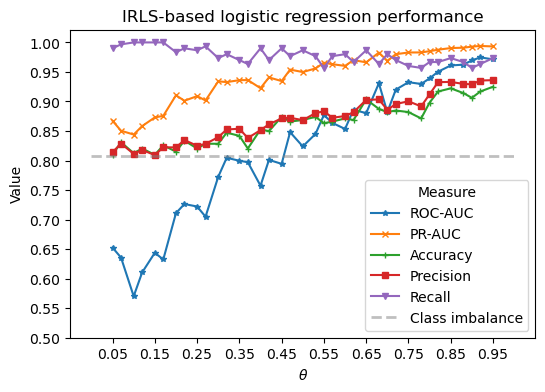

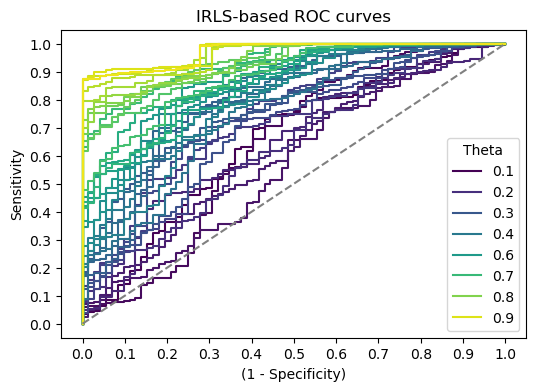

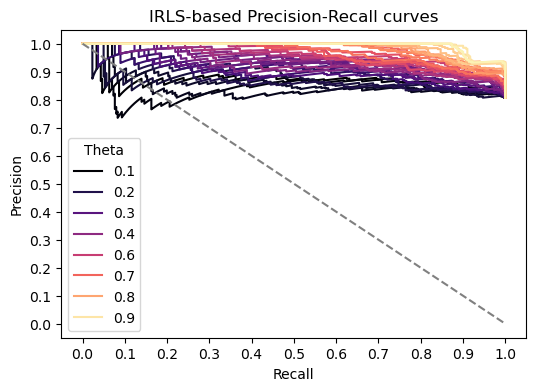

In [68]:
plt.figure(figsize=(6,4))

plt.scatter(converged_betas[:, 0], converged_betas[:, 1], c=THETAS)

plt.colorbar(label="Theta")
plt.xlabel("Intercept")
plt.ylabel("Embedding Coefficient")

plt.title("IRLS-based logistic regression coefficients")

plt.figure(figsize=(6,4))

plt.plot(THETAS, aurocs, marker="*", markersize=4, label="ROC-AUC")
plt.plot(THETAS, auprs, marker="x", markersize=4, label="PR-AUC")
plt.plot(THETAS, accuracies, marker="+", markersize=4, label="Accuracy")
plt.plot(THETAS, precisions, marker="s", markersize=4, label="Precision")
plt.plot(THETAS, recalls, marker="v", markersize=4, label="Recall")
plt.hlines(df["layer_actual"].value_counts()[1] / df["layer_actual"].value_counts().sum(), 0, 1, linestyle="--", linewidth=2, color="gray", alpha=0.5, label="Class imbalance")

plt.legend(title="Measure")
plt.xticks(THETAS[::4])
plt.yticks(np.linspace(0.5,1,11))
plt.xlabel("$\\theta$")
plt.ylabel("Value")

plt.title("IRLS-based logistic regression performance")


viridis = mpl.colormaps["viridis"]

plt.figure(figsize=(6,4))

for idx, theta in enumerate(THETAS):
    curve = rocs[idx]
    if idx % 5 == 0:
        plt.plot(curve[0], curve[1], color=viridis(idx/len(THETAS)), label=f"{theta:.1f}")
    else:
        plt.plot(curve[0], curve[1], color=viridis(idx/len(THETAS)))

plt.plot(np.linspace(0,1), np.linspace(0,1), linestyle="--", color="gray")

plt.legend(title="Theta")
plt.xticks(np.linspace(0,1,11))
plt.yticks(np.linspace(0,1,11))
plt.xlabel("(1 - Specificity)")
plt.ylabel("Sensitivity")

plt.title("IRLS-based ROC curves")

viridis = mpl.colormaps["magma"]

plt.figure(figsize=(6,4))

for idx, theta in enumerate(THETAS):
    curve = prs[idx]
    if idx % 5 == 0:
        plt.plot(curve[1], curve[0], color=viridis(idx/len(THETAS)), label=f"{theta:.1f}")
    else:
        plt.plot(curve[1], curve[0], color=viridis(idx/len(THETAS)))

plt.plot(np.linspace(0,1), 1-np.linspace(0,1), linestyle="--", color="gray")

plt.legend(title="Theta")
plt.xticks(np.linspace(0,1,11))
plt.yticks(np.linspace(0,1,11))
plt.xlabel("Recall")
plt.ylabel("Precision")

plt.title("IRLS-based Precision-Recall curves")